# Investigating Overfitting and Underfitting

[Click here](https://neuronjolt.com/data/downloads/ch_08_investigating_overfitting_and_underfitting.ipynb) to download this chapter as a Jupyter (.ipynb) file.

One of the fundamental concepts of machine learning is the idea that varying a model's flexibility to fit the data on which it is trained can lead to overfitting or underfitting, both of which are detrimental to the model's generalization performance.

***Overfitting*** occurs when the model is too flexible to fit the training data. When the model is too flexible to fit the training data it learns the patterns in the training data too well, because it learns not only the patterns in the training data that are reflective of the population, but also the random noise in the training data that is NOT reflective of the population. When the overfit model is applied to new data from the population it underperforms because it is looking for the noise from the training data that is not reflective of the population.

***Underfitting***, in contrast, is when the model is not flexible enough to fit the training data. This results in a very simple model that cannot learn even the patterns in the training data that are reflective of patterns in the population. When this underfit model is applied to ne data from the population it also underperforms because it didn't learn as many patterns from the data as it could have if it was more flexible.

Notice that both overfitting and underfitting are caused by the model's flexibility to fit the training data being sub-optimal. By varying the model's flexibility to fit the training data from very inflexible to very flexible we can observe the model moving from underfitting, to peak performance where it neither underfits nor overfits, then to overfitting. In this chapter we will do just that using a tool called a ***validation curve graph***.

The technical term for this tradeoff between underfitting and overfitting is the ***bias-variance tradeoff***. ***Bias*** and ***variance*** are two different sources of error in a model. ***Bias*** refers to the error caused by representing real-world relationships in data that may be very complex with a model that is too simplistic. This leads to underfitting. An example of a high-bias model would be a simple linear regression model, which produces a straight line as its prediction, being used to make predictions for a data relationship that is actually U-shaped. ***Variance*** refers to the model’s sensitivity to fluctuations in the training data. In other words, it refers to the model's flexibility to fit the training data. High-variance models are too sensitive to fluctuations in the training data, capturing noise as if it were a real pattern. This results in overfitting. An example would be a linear regression model with several higher-order polynomial terms added, which can fit lots of noise in the training data, being used to make predictions for a data relationship that is actually U-shaped. Overfit models have high performance on training data but fail to generalize well to new data from the population. 

This tension between having a model that is too sensitive to the training data and having a model that is not sensitive enough to the training data is called the ***bias-variance tradeoff***. The way to reduce bias is to make the model more flexible. This, however, increases the model's variance. 

The ideal model has the combination of bias and variance that leads to the lowest total error. In other words, the ideal model has a level of flexibility to fit the training data that leads to the model's highest possible generalization performance because it is neither underfitting nor overfitting.

Next we will import some real data on the California housing market and investigate the relationship between model flexibility, overfitting and underfitting in more detail using K-nn models.

## Module and Function Imports

In [1]:
import pandas as pd
import numpy as np

from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_hline,
    scale_x_reverse,
    labs
)

from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor

## K-nn Regression Validation Curve Plot

### The California Housing Data

Scikit-learn provides tools to create, load, or download datasets that can be used to practice or illustrate machine learning concepts. One of those datasets is the California Housing dataset. Below we use the `fetch_california_housing()` function to download and load this dataset. 

Notice that scikit-learn provides most datasets in a container called a ***Bunch***. A ***Bunch*** is a container object similar to a python dict, but it enables its values to be accessed either by key, like a dict, or as attributes via dot notation.

In [2]:
ca = fetch_california_housing()

In [3]:
type(ca)

sklearn.utils._bunch.Bunch

Like a python dict, a Bunch object has a `keys()` method that can be used to show the keys in the Bunch. These keys can then be used to access values in the Bunch, which are either parts of the dataset or information about the dataset. Notice that the data itself is stored as numpy arrays, with the features separated from the target. The features are typically accessed with the `data` key and the target variable values are typically accessed with the `target` key. There are separate keys that may be used to access the column names for the features (`feature_names`) and the target variable (`target_names`). 

In [4]:
ca.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [5]:
ca.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [6]:
ca.target_names

['MedHouseVal']

The `DESCR` key is associated with a description of the dataset. Let's take a look at the description for the California Housing data.

In [7]:
print(ca.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

We see that the data is from the 1990 Census. It has information on housing for Census block groups in CA, including information about the Census block group and the houses in it, and the median house value within the Census block group. We will build a model to predict the mean house price from the other information about the Census block group and the houses in it.

First, let's assign the features to the variable `X` and the target to the variable `y`.

In [8]:
# Assign features and target to X and y
X = ca.data
y = ca.target

### Generate the data to build the plot

A ***validation curve plot*** graphs a model's performance on the training data and the test data at different levels of flexibility to fit the training data. 

For K-nn models the parameter that controls how flexible the model is to fit the training data is $k$, which refers to the number of neighbors used to make the prediction. The fewer the number of neighbors used to make the prediction the more flexible the K-nn model is to fit the training data. So, we will investigate the performance of K-nn models at various levels of $k$ on both the training and testing data. We will not base our performance estimates on a single split, however. We will do multiple train-test splits, and for each split we will build and test models with each possible candidate value for $k$.

First, let's define some variables. We will try K-nn models with $k$ varying from $k = 1$ to $k = 26$, so we assign `range(1, 26)` to a variable named `k_params`. The `splits` variable will represent how many train-test splits we will do. For each split a model will be built and tested for each level of $k$. `train_res` and `test_res` are numpy multidimensional arrays to keep track of the results. The arrays are created initially with zeros, with a row for each value of $k$ and a column for each split. With 25 values of $k$ to try and 10 splits we will be building and testing 250 K-nn models! `train_res` and `test_res` will hold the score for each run.

In [9]:
# define which k parameters to try 
k_params = range(1, 26)

# set the number of random train-test splits
splits = 10

# Create multidimensional numpy arrays to hold performance results (Later will average for each level of k)
train_res = np.zeros(shape = (len(k_params), splits))
test_res = np.zeros(shape = (len(k_params), splits))


The code below uses a nested loop structure to do 10 random train-test splits of the data, and investigate values of $k$ from 1 to 25 for each split. For each split the model is built on the training data, then tested on the test data for each value of $k$. We find the $k$ value that results in the best average performance on the test data, and then plot a validation curve of the results to see a visual representation of the patterns of performance vs model flexibility. 

The code makes use of several tools from scikit-learn:

* The random splitting of the data into training data and test data is accomplished with the `train_test_split()` function. The `train_test_split()` function splits same-indexed input arrays, with 75% of the row indexes in each input array becoming the training data and 25% of the row indexes indexes in each input array becoming the test data by default. So, when we pass it our features `X` and target variable values `y` it splits them into 75% training data and 25% test data, maintaining the correspondence between the rows because the row indexes allocated to training and test data are the same indexes for each input array. The function returns the arrays that are the result of splitting the input arrays. Since the first argument to the function is the features, `X` the first two arrays returned are the training features and the test features. Then, because the next argument to the function is the target variable values the next two arrays returned are the training target values and the test target values
* The data is scaled after each split with an instance of `MinMaxScaler()`
* The `KNeighborsRegressor()` constructor function is used to create an instance of a K-nn estimator for regression
* The `fit()` and `score()` methods of the K-nn estimator are used to fit the model to the scaled training data and score it on the scaled test data

In the code, notice how the loop variables are used to control the number of splits, set the value of the `n_neighbors` parameter to  `KNeighborsRegressor()`, and serve as the index values for the insertion of the performance scores into the results arrays we have created. Notice also that messages are printed at the beginning of each loop so that we can monitor the code's progress.

In [10]:
# Nested loop structure. Split data in outer loop, loop through k values in inner loop
# This ensures that each candidate value of k will be tested in the same way

for split in range(splits):
    # Print message
    print(f"\nSplit {split + 1}")
    
    # Split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # Scale the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Inner loop tries the model for each of the values of k
    for idx, k in enumerate(k_params):
        # Print message
        print(f"k = {k}", end = '')
        if k != 25: 
            print(", ", end = '')
        
        # Create the regression model
        kreg = KNeighborsRegressor(n_neighbors = k)
        
        # Fit the regression model to the training data
        kreg.fit(X_train_scaled, y_train)
        
        # Score the model on training data and add to results matrix
        train_res[idx, split] = kreg.score(X_train_scaled, y_train)
        
        # Score the model on testing data and add to results matrix
        test_res[idx, split] = kreg.score(X_test_scaled, y_test)
    


Split 1
k = 1, k = 2, k = 3, k = 4, k = 5, k = 6, k = 7, k = 8, k = 9, k = 10, k = 11, k = 12, k = 13, k = 14, k = 15, k = 16, k = 17, k = 18, k = 19, k = 20, k = 21, k = 22, k = 23, k = 24, k = 25
Split 2
k = 1, k = 2, k = 3, k = 4, k = 5, k = 6, k = 7, k = 8, k = 9, k = 10, k = 11, k = 12, k = 13, k = 14, k = 15, k = 16, k = 17, k = 18, k = 19, k = 20, k = 21, k = 22, k = 23, k = 24, k = 25
Split 3
k = 1, k = 2, k = 3, k = 4, k = 5, k = 6, k = 7, k = 8, k = 9, k = 10, k = 11, k = 12, k = 13, k = 14, k = 15, k = 16, k = 17, k = 18, k = 19, k = 20, k = 21, k = 22, k = 23, k = 24, k = 25
Split 4
k = 1, k = 2, k = 3, k = 4, k = 5, k = 6, k = 7, k = 8, k = 9, k = 10, k = 11, k = 12, k = 13, k = 14, k = 15, k = 16, k = 17, k = 18, k = 19, k = 20, k = 21, k = 22, k = 23, k = 24, k = 25
Split 5
k = 1, k = 2, k = 3, k = 4, k = 5, k = 6, k = 7, k = 8, k = 9, k = 10, k = 11, k = 12, k = 13, k = 14, k = 15, k = 16, k = 17, k = 18, k = 19, k = 20, k = 21, k = 22, k = 23, k = 24, k = 25
Split 6
k

### Take a look at the performance results on the test data

The results in the `test_res` array represent $R^2$ scores on the test data for each combination of $k$ (`n_neighbors`) and split. There are 25 rows, one for each value of $k$, and 10 columns, one for each split. 

In [11]:
test_res

array([[0.55557684, 0.5177384 , 0.5450889 , 0.5629676 , 0.54985976,
        0.57291609, 0.5702521 , 0.54161202, 0.56768655, 0.53486734],
       [0.65120325, 0.63194267, 0.64877753, 0.66179498, 0.6441153 ,
        0.66200819, 0.66215936, 0.63793833, 0.65994618, 0.64447637],
       [0.68250406, 0.66559245, 0.67742722, 0.68649423, 0.67989597,
        0.69024863, 0.68893985, 0.66838527, 0.68338016, 0.67880543],
       [0.69962087, 0.68245161, 0.69192849, 0.7002409 , 0.68831389,
        0.69533321, 0.70044253, 0.68051381, 0.69329358, 0.69403579],
       [0.70847657, 0.69211907, 0.70211058, 0.70579087, 0.69893402,
        0.70331076, 0.70567936, 0.68859401, 0.7009194 , 0.7029933 ],
       [0.71309037, 0.69768562, 0.70603755, 0.71049795, 0.70295544,
        0.70709181, 0.70956499, 0.69695764, 0.70544264, 0.70668958],
       [0.71224185, 0.69987986, 0.70665573, 0.71063159, 0.70525246,
        0.70941569, 0.71106747, 0.69970809, 0.70614233, 0.70752333],
       [0.71339644, 0.70099188, 0.7079195

To see the mean test performance across the splits for each value of $k$ we can calculate the row means. We do this calculation with numpy arrays in a way that is very similar to how we would do it with a pandas DataFrame: apply the `mean()` method to the array, and set the `axis = 1` parameter to specify that the mean should be calculated *across* the columns axis, which means calculate the row means.

In [12]:
# Take a look at the row means
test_res.mean(axis = 1)

array([0.55185656, 0.65043622, 0.68016733, 0.69261747, 0.70089279,
       0.70560136, 0.70685184, 0.70787005, 0.70720433, 0.70665952,
       0.70569821, 0.70489887, 0.70413357, 0.70301133, 0.70242851,
       0.70179379, 0.70061323, 0.70014817, 0.69921089, 0.69844555,
       0.69750965, 0.69655171, 0.69585788, 0.69488355, 0.69402213])

We can put the mean train and test $R^2$ for each value of $k$ into a DataFrame to make the data easier to view and work with.

In [13]:
# Put results into a DataFrame
results = pd.DataFrame({'k': k_params,
                        'train_r2': train_res.mean(axis = 1),
                        'test_r2': test_res.mean(axis = 1)}) 


In [14]:
# View the results DataFrame
results.sort_values(by = 'k', ascending = False)

k  train_r2   test_r2
24  25  0.721046  0.694022
23  24  0.722689  0.694884
22  23  0.724260  0.695858
21  22  0.725920  0.696552
20  21  0.727881  0.697510
19  20  0.729988  0.698446
18  19  0.732169  0.699211
17  18  0.734657  0.700148
16  17  0.737242  0.700613
15  16  0.740177  0.701794
14  15  0.743096  0.702429
13  14  0.746437  0.703011
12  13  0.749953  0.704134
11  12  0.753852  0.704899
10  11  0.758175  0.705698
9   10  0.763369  0.706660
8    9  0.769077  0.707204
7    8  0.775577  0.707870
6    7  0.782894  0.706852
5    6  0.791320  0.705601
4    5  0.802495  0.700893
3    4  0.819111  0.692617
2    3  0.843409  0.680167
1    2  0.887327  0.650436
0    1  1.000000  0.551857

We can use the `idxmax()` method on the column for test $R^2$ to return the index at which that column's maximum value occurs. We can then view the entire row at this index of the DataFrame to see the value of $k$ associated with the highest test performance. This is the value of $k$ that produces the level of model flexibility that leads to neither underfitting nor overfitting.

In [15]:
# Find the k resulting in the highest Mean R-squared
results.iloc[results['test_r2'].idxmax()]

k           8.000000
train_r2    0.775577
test_r2     0.707870
Name: 7, dtype: float64

### Plot the Validation Curve

A Validation curve graph has a performance measure on the y-axis axis and a parameter that controls model flexibility on the x-axis. Performance on both training and validation data are plotted across the range of the flexibility parameter. The x-axis sometimes needs to be reversed so that model flexibility increases from left to right. This is the case with K-nn models, because model flexibilty increases as $k$ *decreases*.

We will use plotnine to plot the validation graph, but we first need to use the DataFrame `melt()` method to convert the results data to long format so that we have a column (the `Performance` column in the `results_long` DataFrame) to assign to the `color` parameter to tell plotnine to make separate lines for the training and test performance.

In [16]:
results_long = results.melt(id_vars=["k"]).rename(columns = {'variable' : 'Performance', 
                                                             'value' : 'R-squared'})

results_long.sample(5)

k Performance  R-squared
11  12    train_r2   0.753852
22  23    train_r2   0.724260
27   3     test_r2   0.680167
49  25     test_r2   0.694022
26   2     test_r2   0.650436

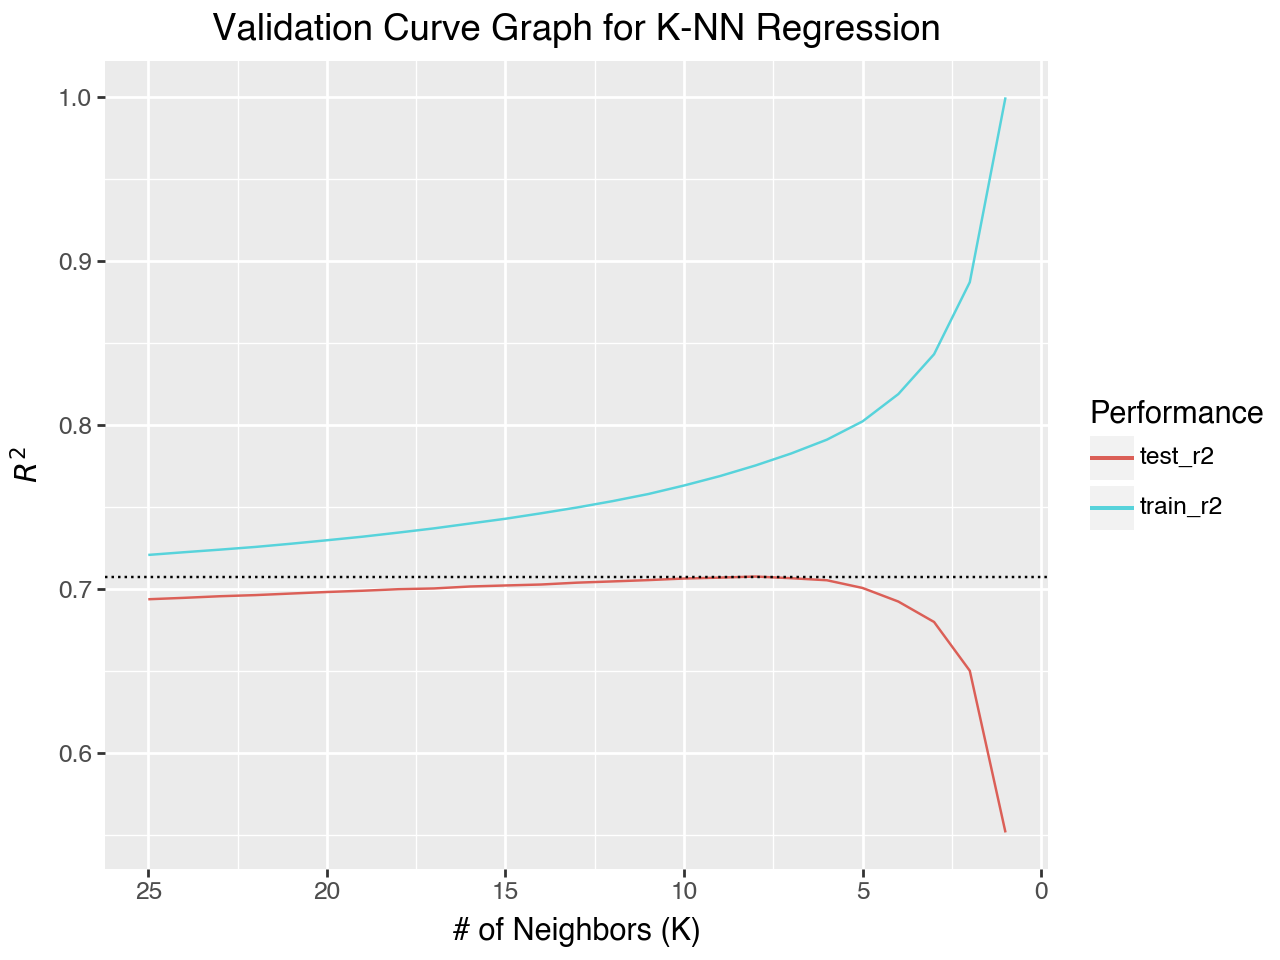

In [17]:
# Create the validation curve graph

(
    ggplot(data = results_long, mapping = aes(x = 'k', y = 'R-squared', color = 'Performance'))
    + geom_line()
    + geom_hline(yintercept = results.iloc[results.test_r2.idxmax()]['test_r2'], linetype = ':')
    + scale_x_reverse()
    + labs(title = "Validation Curve Graph for K-NN Regression",
           x = "# of Neighbors (K)",
           y = "$R^2$")
)

Here we see a typical pattern for a validation curve plot. At the left side of the plot the model is not very flexible to fit the training data. Thus, the model has high bias and underfits the training data, resulting in reduced performance on both the training and test data. The performance on training data typically increases as we move from left to right and the model becomes more flexible. The performance on the test data initially increases as the model becomes more flexible because the increased flexibility allows the model to reflect patterns in the training data that are reflective of the population. Eventually the model's peak performance is reached. This is where the model is neither underfitting nor overfitting. As flexibility increases beyond that point of peak performance, however, test performance decreases as the model becomes too flexible and starts to reflect noise in the training data that is not reflective of the population.

To make it easier to identify the point of peak performance on the testing data we added a horizontal dotted line to the plot at the highest mean test performance ($R^2$) value. The test performance curve is tangent to this line at the best value of $k$.

## Lessons Learned from the Validation Curve Plot

We plotted this validation curve graph not because it is a vital step in building a machine learning model - it isn't - but because it illustrates one of the most important fundamental concepts of supervised machine learning, the relationship between model flexibility to fit the training data and model performance. In more technical terms, it illustrates the bias-variance tradeoff. The specific validation curve graph we plotted used a K-nn model on the California Housing data. Just as the flexibility of a K-nn model to fit the training data may be manipulated by changing the value of the $k$ (`n_neighbors` in scikit-learn) parameter, most other algorithms that can be used in supervised machine learning models also have a parameter that can be set to different values to control the model's flexibility to fit the training data. So, we could construct a similar graph using different algorithms on different data and the pattern of the graph would be the same. 

Because most algorithms that can be used in supervised machine learning models do have parameters that influence the model's flexibility to fit the training data an important part of model building must be to somehow determine what parameter setting is best, that is, what parameter setting leads to the best test performance by hitting the "sweet spot" between underfitting and overfitting. The step in the model building process that does this is called ***model tuning*** or ***hyperparameter tuning***. We will learn more about it in a later chapter. It is accomplished by a process very similar to the one we implemented to create the data for the validation curve plot.

Finally, the code to create the plot illustrates that a specific model's performance is often estimated by calculating mean peformance of the model over several train-test splits. At each split the model is trained on the training data and tested on the test data.